# <u>Geoscore Filter & Plotting</u>

This notebook provides worked examples of the [`geoscore_filter()`](#geoscore) filter and where it should be used, there is also a worked example of how to use the [`filter_fig()`](#figure). Both tools are found in the `lydwhitt-tools` package.

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import lydwhitt_tools as lwt
import numpy as np

In [2]:
df = pd.read_excel('example_data/Geoscore_filter_ExampleData.xlsx', sheet_name="Sheet1")

## Geoscore

### <span style="color:#b03a2e"><b>Important:</b> This filter is intended to highlight potential outliers in large literature datasets to support subsequent manual inspection. It should <u>NOT</u> be used as a fully automated method for data removal, and flagged points should always be assessed in context.

#### <i>What is the geoscore filter and when would I use it?</i>

The `geoscore_filter()` filter is derived from my own experience compiling geochemical datasets, whether for one volcano or a regional study. When compiling large datasets from multiple studies there can be various issues, such as multiple papers using the same underlying dataset, studies isolating specific geological features which bias the data, or simply bad analysis points that were not filtered out by the original authors. The logic behind this filter is to process and display the data, identify broad trends, and flag potential points that are not in keeping with the rest of the dataset. Once these points are identified they can be manually assessed using the literature source and any additional context to decide whether the analysis fits within your intended study, and why it does not follow the general patterns.

Filtering geochemical data for outliers is notoriously difficult because natural datasets always contain real outliers. This filter follows the same steps I would use to visually assess and clean a dataset manually, but streamlines the process and makes the decision logic explicit and reproducible.

First, the filter applies phase-specific recalculations and selects an appropriate progress variable (for example MgO in liquids or An in plagioclase). Smooth compositional trends are then fitted between this progress variable and a set of major elements that are expected to evolve systematically. A robust, local deviation is calculated for each data point relative to these trends, allowing for curvature and non-linear evolution along a liquid line of descent. Each point is scored based on how well it follows the dominant trends across all axes, producing a continuous `trend_score` between 0 and 1.

Next, each major element is evaluated independently using a Kernel Density Estimate (KDE) to assess where individual analyses sit relative to the bulk of the dataset. For each element, the filter identifies a high-density region that captures the main population of the data and records whether each analysis falls within this region. In addition, the dominant KDE peaks are identified and each analysis is assigned a continuous proximity score based on its distance from the nearest peak. These per-element proximity scores are combined using the median to produce a single `cluster_score` between 0 and 1, while a separate diagnostic (mode_hits) records how many elements place an analysis within the high-density core of the dataset.

Finally, the geo_score is calculated as the higher of the `trend_score` and the `cluster_score`, ensuring that analyses which either follow coherent geochemical trends or clearly belong to the main compositional clusters are retained. A user-defined threshold is then applied to produce a boolean `final_pass` flag.

Importantly, this filter is intended to highlight potentially problematic or unusual analyses rather than to automatically remove data. All flagged points should be manually inspected using the original literature, analytical context, and geological setting to determine whether they are appropriate for a given study.

#### <i>How the `geoscore_filter()` function works</i>

The `geoscore_filter()` function is an end-to-end geochemical filtering pipeline designed to help identify potential outliers in large literature datasets. It is based on the same steps I would use to visually inspect and clean data manually (trend checking and density checking), but streamlines the workflow and makes the logic reproducible and transparent.  

The filter works by:
1) recalculating phase chemistry (so you are comparing like-with-like),  
2) fitting smooth compositional trends against an evolving progress variable,  
3) scoring each analysis by how well it follows the dominant trends (`trend_score`),  
4) scoring each analysis by how well it sits within the main high-density KDE populations (`cluster_score`),  
5) combining these into a final continuous `geo_score` (0 to 1) and a boolean `final_pass`.

- **Input:** A <span style="color:#4a78a8"><b>DataFrame</b></span> containing major element chemistry for a single phase, and a phase label  
  <span style="color:#2f7d32"><b>phase</b></span> (<b>"Liq"</b>, <b>"Plg"</b>, or <b>"Cpx"</b>).  
  Optional inputs include a smoothing function (<span style="color:#2f7d32"><b>smooth_fn</b></span>) and smoothing settings (<span style="color:#2f7d32"><b>smooth_kwargs</b></span>).

  #### Phase-specific behaviour

The behaviour of `geoscore_filter()` depends on the mineral or melt phase being analysed. For each phase, a specific progress variable is selected, along with a set of major elements used for trend fitting and KDE-based clustering. These choices reflect common petrological expectations for how compositions evolve within each phase.

The table below summarises the default phase-specific configuration used by the filter.

| Phase | Progress variable (`t`) | Elements used for trend fitting | Elements used for KDE clustering |
|------|--------------------------|---------------------------------|----------------------------------|
| Liquid (Liq) | MgO<sub>Liq</sub> | SiO<sub>2</sub>, FeO<sub>T</sub>, CaO, Al<sub>2</sub>O<sub>3</sub>, K<sub>2</sub>O | SiO<sub>2</sub>, MgO, FeO<sub>T</sub>, CaO, Al<sub>2</sub>O<sub>3</sub>, Na<sub>2</sub>O, K<sub>2</sub>O, TiO<sub>2</sub> |
| Plagioclase (Plg) | An | CaO, Na<sub>2</sub>O, K<sub>2</sub>O | CaO, Na<sub>2</sub>O, K<sub>2</sub>O, Al<sub>2</sub>O<sub>3</sub>, SiO<sub>2</sub> |
| Clinopyroxene (Cpx) | Mg# | MgO, FeO<sub>T</sub>, CaO, TiO<sub>2</sub> | MgO, FeO<sub>T</sub>, CaO, TiO<sub>2</sub>, Al<sub>2</sub>O<sub>3</sub>, SiO<sub>2</sub> |

These phase-specific choices are intentionally prescriptive rather than fully automated. The progress variables and element sets are selected to reflect expected crystallisation or differentiation behaviour for each phase, while still allowing for non-linear evolution and natural scatter. The filter does not assume that all elements must follow a single trend, nor that all samples belong to a single compositional population. By making these phase-dependent assumptions explicit, the filter avoids hidden decision-making and allows users to assess whether the default configuration is appropriate for their dataset or requires modification.

- **Output:** A <span style="color:#4a78a8"><b>dict</b></span> containing:
  - <span style="color:#4a78a8"><b>['df']</b></span> → the recalculated and scored <span style="color:#4a78a8"><b>DataFrame</b></span>, including:
    - <span style="color:#2f7d32"><b>['trend_score']</b></span> (0 to 1): how well each point follows the fitted trends  
    - <span style="color:#2f7d32"><b>['cluster_score']</b></span> (0 to 1): how well each point sits within the KDE high-density populations  
    - <span style="color:#2f7d32"><b>['geo_score']</b></span> (0 to 1): the final combined score  
    - <span style="color:#2f7d32"><b>['final_pass']</b></span> (True/False): whether the point is retained at the chosen threshold
    - <span style="color:#2f7d32"><b>['mode_hits']</b></span>: diagnostic count of how many major elements place the point inside the KDE high-density region
  - <span style="color:#4a78a8"><b>['diagnostics']</b></span> → a dictionary storing the internal settings and outputs used to generate plots (e.g. chosen progress variable, KDE thresholds, peak intervals, and which columns were used)
  - <span style="color:#4a78a8"><b>['membership']</b></span> → optional KDE membership matrix (only returned if <span style="color:#2f7d32"><b>return_membership=True</b></span>)

**Example usage:**
- <span style="color:#4a78a8"><b>df</b></span> → the input DataFrame  
- <span style="color:#2f7d32"><b>"Liq"</b></span> → the phase label  


In [3]:
df

,Sample_ID,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,CaO_Liq,MgO_Liq,MnO,K2O_Liq,Na2O_Liq,P2O5,Total
0,ID00376,47.98,1.95,17.51,10.386454,11.59,6.21,0.16,0.32,2.64,0.22,99.02
1,ID00377,47.92,3.53,13.32,14.482246,8.66,4.63,0.22,0.63,3.32,0.47,97.09
2,ID00378,70.50,0.41,13.50,4.498718,1.83,0.26,0.13,2.89,5.48,0.08,99.64
3,ID00529,47.84,3.19,13.42,12.411606,11.56,6.21,0.10,0.38,2.63,0.21,98.44
4,ID00560,66.87,0.66,12.55,4.285632,1.10,0.60,0.09,3.08,5.32,0.06,94.74
...,...,...,...,...,...,...,...,...,...,...,...,...
114,ID05364,56.88,1.95,13.28,11.769384,5.52,1.99,0.31,1.42,4.71,0.86,100.00
115,ID00223,70.04,0.29,13.45,4.280000,1.75,0.30,NaN,2.81,4.57,0.09,93.21
116,ID02066,70.60,0.41,13.33,4.205732,1.52,0.28,0.16,2.85,5.73,0.04,99.22
117,ID02067,70.60,0.41,13.17,4.788798,1.73,0.18,0.18,2.66,5.73,0.03,99.55


In [4]:
# 1) Run the geoscore filter on liquid data
out = lwt.geoscore_filter(
    df,
    phase="Liq",
    return_membership=False,   # set to True if you want the membership matrix for debugging/plotting
)

# 2) Pull out the outputs you’ll actually use
df_filt = out["df"]                  # recalculated + scored dataframe
diagnostics = out["diagnostics"]     # everything needed for plotting / transparency

# 3) Quick sanity checks
df_filt[["geo_score", "trend_score", "cluster_score", "final_pass"]].head()

,geo_score,trend_score,cluster_score,final_pass
0,0.217668,0.147817,0.217668,False
1,0.831767,0.193432,0.831767,True
2,0.834540,0.600807,0.834540,True
3,0.594721,0.555687,0.594721,True
4,0.842758,0.842758,0.464986,True


In [5]:
# How many points are kept?
kept = df_filt["final_pass"].sum()
tot = len(df_filt)
print(f"Kept {kept} / {tot} ({kept/tot:.1%})")

# 4) (Optional) Subset to only the kept points
df_kept = df_filt[df_filt["final_pass"]].copy()
df_removed = df_filt[~df_filt["final_pass"]].copy()

Kept 115 / 119 (96.6%)


## Figure

#### <i>What is the filter figure and when would I use it?</i>

The `filter_fig()` function generates a multi-panel diagnostic figure that visualises how the `geoscore_filter()` behaves for a given dataset. It shows the distribution of filtering scores, the relationship between trend-based and density-based metrics, the fitted compositional trends used to calculate the `trend_score`, and the KDE structures used to calculate the `cluster_score`. Together, these panels make it clear why individual analyses are retained or flagged and allow the user to assess whether the filter is behaving in a geologically sensible way.

> <span style="color:#2c5aa0"><b>Research note:</b> I use this figure to visually validate the behaviour of the geochemical filter, inspect flagged analyses in the context of major-element trends and density structure, and assess the sensitivity of the results to different filtering thresholds before making any manual decisions.</span>

#### <i>How the `filter_fig()` function works</i>

- **Input:** A <span style="color:#4a78a8"><b>DataFrame</b></span> produced by the `geoscore_filter()` function, containing the calculated  
  <span style="color:#2f7d32"><b>['geo_score']</b></span>,  
  <span style="color:#2f7d32"><b>['trend_score']</b></span>, and  
  <span style="color:#2f7d32"><b>['cluster_score']</b></span> columns, along with the associated  
  <span style="color:#4a78a8"><b>diagnostics</b></span> dictionary returned by the filter.

- **Output:** A <span style="color:#4a78a8"><b>Figure</b></span> where the filtering behaviour is visualised using a multi-panel diagnostic plot. This figure shows the distribution of <span style="color:#2f7d32"><b>geo_score</b></span> values, the relationship between <span style="color:#2f7d32"><b>trend_score</b></span> and <span style="color:#2f7d32"><b>cluster_score</b></span>, the fitted compositional <span style="color:#2f7d32"><b>trend curves</b></span>, and the <span style="color:#2f7d32"><b>KDE density structure</b></span> used by the filter.

<span style="color:#b03a2e"><b>Important:</b> The `filter_fig()` function does not apply any additional filtering and does not modify the input <span style="color:#4a78a8"><b>DataFrame</b></span>. It is intended purely as a diagnostic and visualisation tool to explain why analyses were retained or flagged by the `geoscore_filter()` and to assess whether the filter behaves sensibly for a given dataset.</span>

**Example usage:**
- <span style="color:#4a78a8"><b>df_filt</b></span> → the scored <span style="color:#4a78a8"><b>DataFrame</b></span> returned by `geoscore_filter()`  
- <span style="color:#4a78a8"><b>diagnostics</b></span> → the diagnostics dictionary returned by `geoscore_filter()`

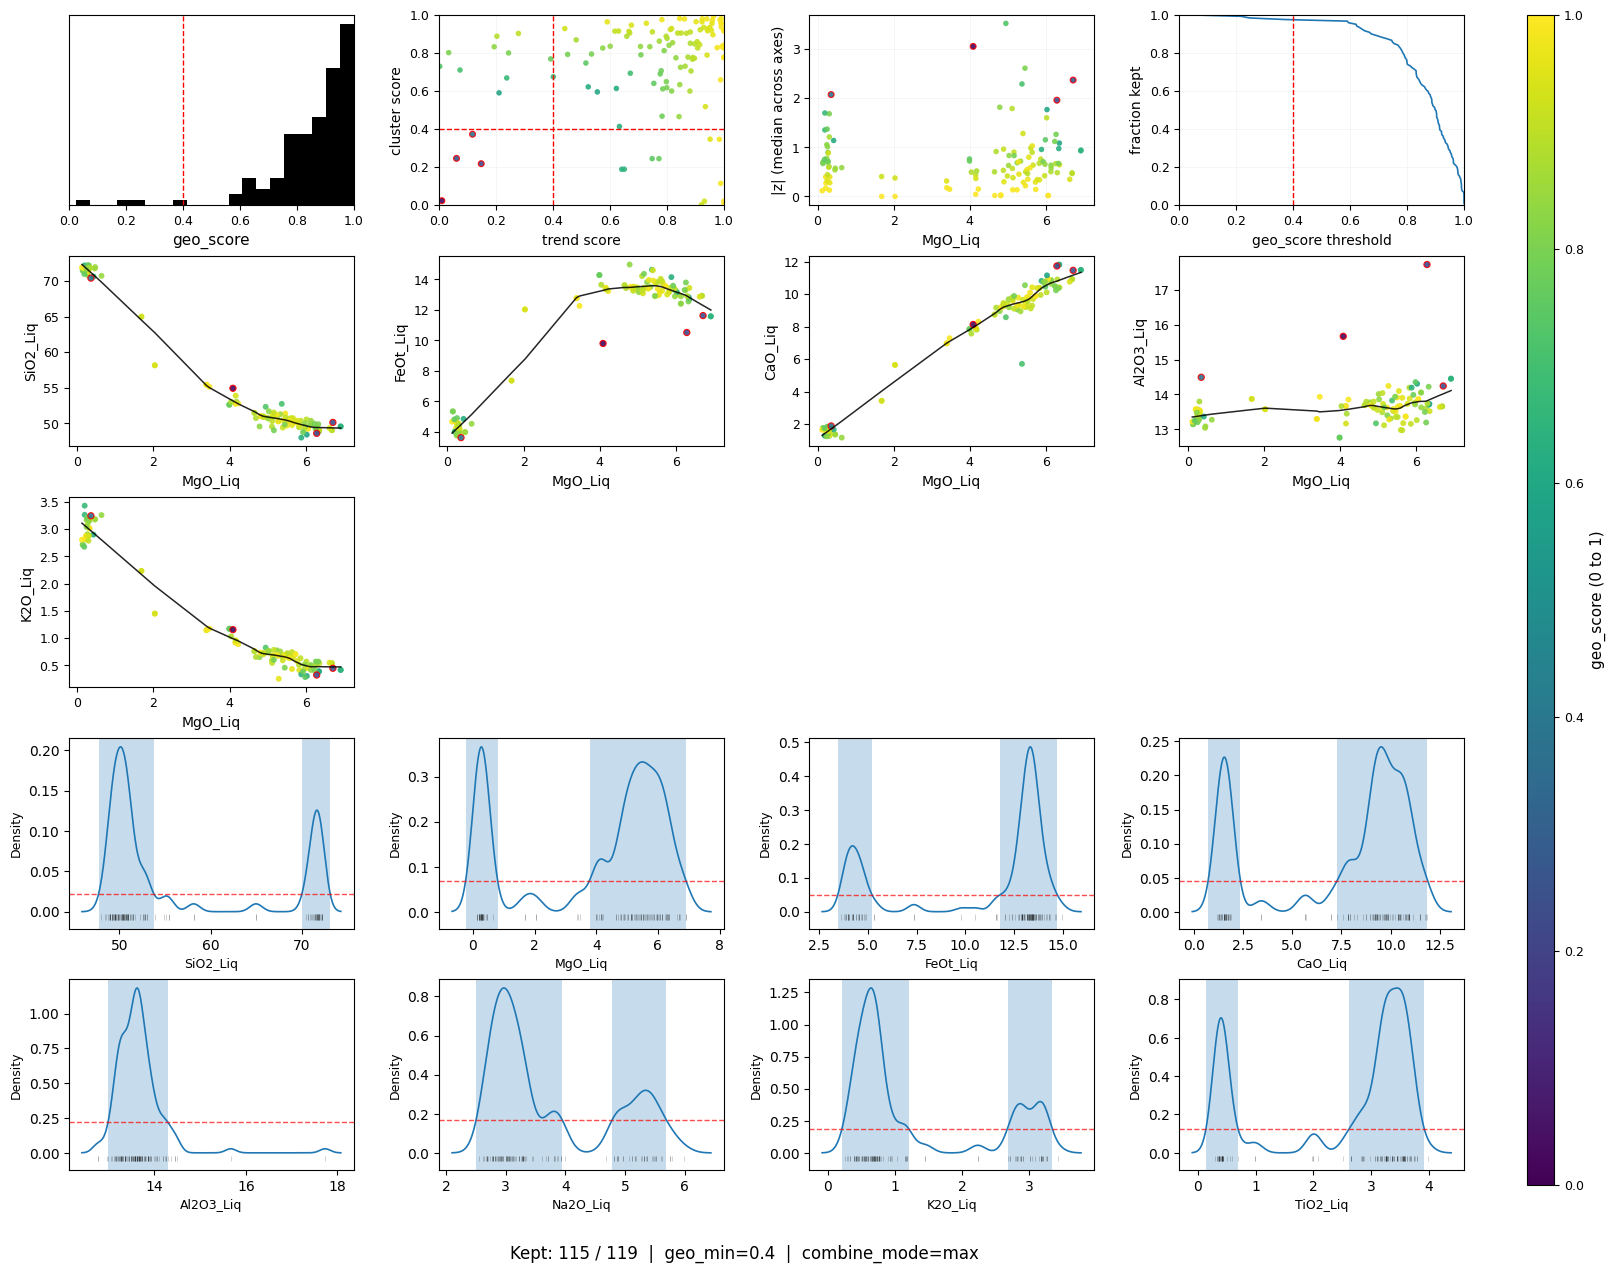

In [6]:
fig = lwt.filter_fig(
    df_filt,
    diagnostics=diagnostics,
    figsize=(18, 15),
    label_fs=11,
    tick_fs=9,
)

<i> Example output from the filter_fig() function, showing how the geoscore filter evaluates and flags geochemical data.
The upper panels introduce the overall behaviour of the filter: the distribution of geo_score values across the dataset, how trend_score and cluster_score combine, and how changing the geo_min threshold affects the proportion of analyses retained.

The middle panels show how individual analyses compare to smooth compositional trends for selected major elements plotted against a progress variable (here MgO). Points are coloured by their final geo_score, allowing users to see how deviations from expected geochemical trends influence scoring.

The lower panels display Kernel Density Estimates for each element, with shaded regions indicating the dominant high-density populations identified by the filter. These density structures are used to assess whether an analysis belongs to the main compositional population or lies in a lower-density tail.

By stepping through these panels from top to bottom, the figure shows how trend consistency and population membership are evaluated separately and then combined into a single score. This makes it clear why specific analyses are flagged, and encourages users to judge whether flagged points reflect real geological variability or potential issues in the compiled dataset.</i>